# **E-Commerce Customer Churn Prediction**
- Alfidhiya Amany R.
---
---

## üìñ **Library Import**

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# data splitting
from sklearn.model_selection import train_test_split

# scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# encoding
from sklearn.preprocessing import OneHotEncoder
from category_encoders import BinaryEncoder, OrdinalEncoder

# missing values
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# binning
from sklearn.preprocessing import KBinsDiscretizer

# polynomial features
from sklearn.preprocessing import PolynomialFeatures

# column transfornmer
from sklearn.compose import ColumnTransformer

# pipeline
from sklearn.pipeline import Pipeline
# Selalu pakai ketika ingin pakai pipeline tetapi ada step balancing data
from imblearn.pipeline import Pipeline

# imbalanced
from imblearn.under_sampling import RandomUnderSampler, CondensedNearestNeighbour, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE

# cross validation
from sklearn.model_selection import cross_val_score

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# modeling
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# modeling -> ensemble various type
from sklearn.ensemble import VotingClassifier, StackingClassifier

# ensemble similar type
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier


# metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Suppress Warning
import warnings
warnings.filterwarnings('ignore')

# XGBoost
from xgboost.sklearn import XGBClassifier

# Max Column
pd.set_option('display.max_columns', None)

# Save Model
import joblib
import pickle

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_curve, roc_auc_score, RocCurveDisplay, make_scorer, fbeta_score

# Model Interpretation
import shap
import lime

# MSNO
import missingno as msno

# Shapiro-Wilk Normality Test
from scipy.stats import shapiro

## üîÑÔ∏è **Workflow in CRISP-DM**
1. [Business Understanding and Problem Framing](#1-business-understanding-and-problem-framing)
2. [Data Understanding](#2-data-understanding)
3. [Data Preparation](#3-data-preparation)
4. [Cross Validation (Model Benchmark)](#4-cross-validation-model-benchmark)
5. [Cross Validation + Resampling](#5-cross-validation--resampling)
6. [Hyperparameter Tuning](#6-hyperparameter-tuning)
7. [Predict to Test Set](#7-predict-to-test-set)
8. [ROC and AUC](#8-roc-and-auc)
9. [Features Importance](#9-features-importance)
10. [Final Model and Saving Model](#10-final-model-and-saving-model)
11. [Model Interpretation](#11-model-interpretation)
12. [Summary](#12-summary)

## **1. Business Understanding and Problem Framing**

### üìï **Latar Belakang**
Perusahaan *e-commerce* menghadapi sebuah tantangan besar yakni untuk terus mempertahankan pelanggan. Salah satu indikator yang menentukan keberhasilan operasional dan strategi retensi adalah mengetahui pelanggan mana saja yang merupakan pelanggan *churn*. *Churn* merupakan kondisi pada saat pelanggan tidak lagi menggunakan layanan maupun melakukan transaksi di suatu *e-commerce* dalam kurun waktu tertentu. Mengetahui mana saja pelanggan yang beresiko *churn* menjadi penting bagi perusahaan untuk melakukan tindakan proaktif dan *actionable* untuk dapat mempertahankan pelanggan. *Machine learning* menjadi solusi yang cukup efektif untuk dapat mengenali pola historis dan data pelanggan yang telah terhimpun, sehingga dapat diberikan prediksi apakah pelanggan tersebut akan *churn* atau tidak akan *churn*.

***Stakeholder*** :
- Tim *Marketing*
    + Menggunakan hasil prediksi untuk menyusun strategi pencegahan *churn* seperti promo, diskon, maupun *campaign event*.
- Manajemen Produk dan Bisnis
    + Menggunakan hasil prediksi dan interpretasi model untuk melakukan evaluasi performa produk sehingga mampu meningkatkan layanan dan pengalaman pelanggan.
- CRM
    + Mengetahui pelanggan yang beresiko *churn* sehingga dapat langsung menjangkau pelanggan tersebut dan melakukan tindakan pencegahan.
- *Board of Directors*
    + Menggunakan hasil prediksi dan tingkat pelanggan *churn* sebagai indikator kesehatan bisnis yang menjadi salah satu pertimbangan dalam pengambilan keputusan bisnis.

### üò© **Problem Framing**
- Perusahaan ingin memprediksi apakah seorang pelanggan diprediksi akan *churn* atau tidak akan *churn*.
- Target:
    + Kelas `1` : *Churn* --> Kelas Positif
    + Kelas `0` : *Not Churn* --> Kelas Negatif
- *Business Metrics*:
    + FN
        - Model memprediksi seorang pelanggan *Not Churn*, namun aktualnya *Churn*.
        - Resikonya adalah perusahaan akan kehilangan pelanggan tanpa adanya upaya pencegahan.
        - Berdampak pada kehilangan pendapatan serta munculnya biaya tambahan untuk menarik pelanggan baru.
        - *Total spending* rata-rata pelanggan di *e-commerce* sebesar [$4200 per tahun](https://www.globaldata.com/data-insights/retail-and-wholesale/e-commerce-spending-per-capita-in-united-states-of-america-2082922/#:~:text=Ecommerce%20spending%20per%20capita%20in%20the%20United%20States%20attained%20a,4%2C240) atau setara dengan $350 per bulan. Median tenure customer 9 bulan.
        $$ Estimated CLV = Avg.Tenure * Avg. Monthly Spent$$
        - Asumsi kerugian akibat FN = 9 bulan * $350 = **$3150** per pelanggan.
 

    + FP
        - Model memprediksi seorang pelanggan *Churn*, namun aktualnya *Not Churn*.
        - Resikonya adalah perusahaan akan mengalami pemborosan dimana promo diberikan kepada pelanggan yang sebenarnya sudah loyal dan tidak akan *churn*.
        - Asumsi kerugian akibat FP : Biaya Promosi dan Diskon sebesar **$10 per pelanggan**.

    + ***Business metrics*** yang digunakan adalah F2 Score. Metrik ini mengukur keseimbangan antara *precision* (menekan FP) dan *recall* (menekan FN), namun model akan lebih fokus pada *recall*. *F2 score* cocok digunakan karena resiko FN dan FP dianggap sama besarnya namun lebih merugikan jika FN tinggi.
        $$ F2 Score = (1 + 2^2) * \frac{Precision * Recall}{(2^2 * Precision) + Recall} $$

### üöÄ **Objectives**
- Membangun model *machine learnin* yang dapat memprediksi pelanggan yang akan *churn* dan pelanggan *not churn*.
- Membangun model *machine learning* yang dapat diinterpretasikan sehingga mampu mengetahui faktor-faktor yang menyebabkan *churn*.
- Mendukung strategi retensi pelanggan yang tepat dan efisien.


## **2. Data Understanding**
| Kolom                    | Deskripsi                                                                 |
|--------------------------|---------------------------------------------------------------------------|
| **Tenure**               | Lama waktu pelanggan menjadi pelanggan di e-commerce.                    |
| **WarehouseToHome**      | Jarak antara gudang dan rumah pelanggan.                                 |
| **NumberOfDeviceRegistered** | Total perangkat yang terdaftar pada akun pelanggan tersebut.         |
| **PreferedOrderCat**     | Kategori pesanan yang paling sering dibeli pelanggan pada bulan lalu. |
| **SatisfactionScore**    | Skor kepuasan pelanggan terhadap layanan.                                |
| **MaritalStatus**        | Status pernikahan pelanggan.                                             |
| **NumberOfAddress**      | Total alamat yang terdaftar untuk pelanggan tersebut.                    |
| **Complaint**            | Indikator apakah ada keluhan yang diajukan pelanggan bulan lalu.         |
| **DaySinceLastOrder**    | Jumlah hari sejak pesanan terakhir oleh pelanggan.                       |
| **CashbackAmount**       | Rata-rata jumlah cashback yang diterima pelanggan pada bulan lalu.       |
| **Churn**                | Status churn pelanggan (apakah berhenti menggunakan layanan).            |


### **Load Dataset**

In [10]:
df = pd.read_csv('../Data/data_ecommerce_customer_churn.csv')
df.head()

Tenure  WarehouseToHome  NumberOfDeviceRegistered    PreferedOrderCat  \
0    15.0             29.0                         4  Laptop & Accessory   
1     7.0             25.0                         4              Mobile   
2    27.0             13.0                         3  Laptop & Accessory   
3    20.0             25.0                         4             Fashion   
4    30.0             15.0                         4              Others   

   SatisfactionScore MaritalStatus  NumberOfAddress  Complain  \
0                  3        Single                2         0   
1                  1       Married                2         0   
2                  1       Married                5         0   
3                  3      Divorced                7         0   
4                  4        Single                8         0   

   DaySinceLastOrder  CashbackAmount  Churn  
0                7.0          143.32      0  
1                7.0          129.29      0  
2                7.0          168.54      0  
3                NaN          230.27      0  
4                8.0          322.17      0

### **Data Cleansing**

In [11]:
# Cek Missing Value
df.isna().sum()

Tenure                      194
WarehouseToHome             169
NumberOfDeviceRegistered      0
PreferedOrderCat              0
SatisfactionScore             0
MaritalStatus                 0
NumberOfAddress               0
Complain                      0
DaySinceLastOrder           213
CashbackAmount                0
Churn                         0
dtype: int64

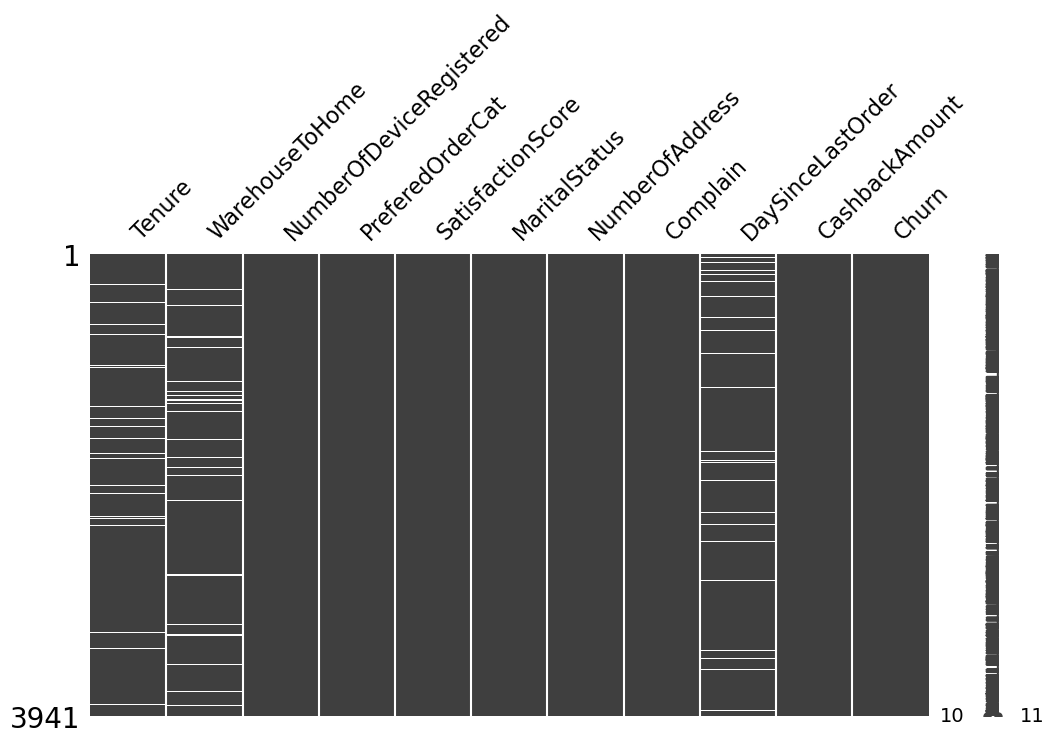

In [12]:
# Missing Value Visualization
msno.matrix(df, figsize=(12, 6));

> Missing Value terjadi pada 3 kolom yakni `Tenure`, `WarehouseToHome`, dan `DaySinceLAstOrder` dan merupakan missing value yang random tidak terisi dan tidak saling terkait satu sama lain. Handling missing value akan dilakukan dalam tahap pre-processing.

In [13]:
# Cek Duplikat
df.duplicated().sum()

671

> Terdapat 671 baris data duplikat. Treatment duplicate tergantung pada proporsi target dan keseimbangan target.

In [14]:
# Proporsi Churn vs Not Churn pada Dataset Asli
df['Churn'].value_counts(normalize=True)

Churn
0    0.828977
1    0.171023
Name: proportion, dtype: float64

In [15]:
# Proporsi Churn vs Not Churn Jika Duplikat Dihapus
df[df.duplicated() != True]['Churn'].value_counts(normalize=True)

Churn
0    0.836697
1    0.163303
Name: proportion, dtype: float64

> Proporsi Churn vs Not Churn tidak berubah drastis apabila akan dilakukan penghapusan duplikat. Namun, indikasi adanya imbalanced data maka keputusannya tidak perlu menghapus duplikat agar tidak menghilangkan terlalu banyak informasi.

In [16]:
# Cek Tipe Data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3941 entries, 0 to 3940
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Tenure                    3747 non-null   float64
 1   WarehouseToHome           3772 non-null   float64
 2   NumberOfDeviceRegistered  3941 non-null   int64  
 3   PreferedOrderCat          3941 non-null   object 
 4   SatisfactionScore         3941 non-null   int64  
 5   MaritalStatus             3941 non-null   object 
 6   NumberOfAddress           3941 non-null   int64  
 7   Complain                  3941 non-null   int64  
 8   DaySinceLastOrder         3728 non-null   float64
 9   CashbackAmount            3941 non-null   float64
 10  Churn                     3941 non-null   int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 338.8+ KB


In [17]:
# Ubah Tipe Data Category dan Mengurutkan urutan Cat
cat_cols = ['PreferedOrderCat', 'MaritalStatus', 'SatisfactionScore', 'Complain', 'Churn']
df[cat_cols] = df[cat_cols].astype('category')

In [18]:
df['MaritalStatus'].unique()

['Single', 'Married', 'Divorced']
Categories (3, object): ['Divorced', 'Married', 'Single']

In [19]:
df['SatisfactionScore'].unique()

[3, 1, 4, 2, 5]
Categories (5, int64): [1, 2, 3, 4, 5]

In [20]:
df['MaritalStatus'] = df['MaritalStatus'].cat.reorder_categories(['Single', 'Married', 'Divorced'])
df['SatisfactionScore'] = df['SatisfactionScore'].cat.reorder_categories([1, 2, 3, 4, 5])

### **Exploratory Data Analysis (EDA)**
- Bagaimana distribusi data kolom numerik?
- Apakah terdapat outlier?
- Bagaimana proporsi kelas target?
- Bagaimana distribusi target Churn vs Not Churn berdasarkan karateristik kategorikal nya?
- Bagaimana korelasi antara setiap fitur dengan target?

#### **Bagaimana distribusi data kolom numerik?**

In [21]:
cols = ['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered','NumberOfAddress',
        'DaySinceLastOrder', 'CashbackAmount']
pvals = []
normality = []
for i in cols:
    stat, pvalue = shapiro(df[df[i].isna()==False][i])
    pvals.append(pvalue)
    if pvalue > 0.05:
        normality.append('Normal')
    else:
        normality.append('Not Normal')

normalilty_df = pd.DataFrame({'Column': cols, 'P-Value': pvals, 'Normality': normality})
normalilty_df

Column       P-Value   Normality
0                    Tenure  6.657973e-41  Not Normal
1           WarehouseToHome  1.156161e-48  Not Normal
2  NumberOfDeviceRegistered  5.962349e-46  Not Normal
3           NumberOfAddress  9.639375e-49  Not Normal
4         DaySinceLastOrder  2.723472e-45  Not Normal
5            CashbackAmount  2.911029e-47  Not Normal

> Semua kolom numerik memiliki nilai p-value hasil uji normalitas shapiro wilk test < alpha (0.05) sehingga semua kolom numerik terdistribusi tidak normal.

#### **Apakah terdapat outlier?**

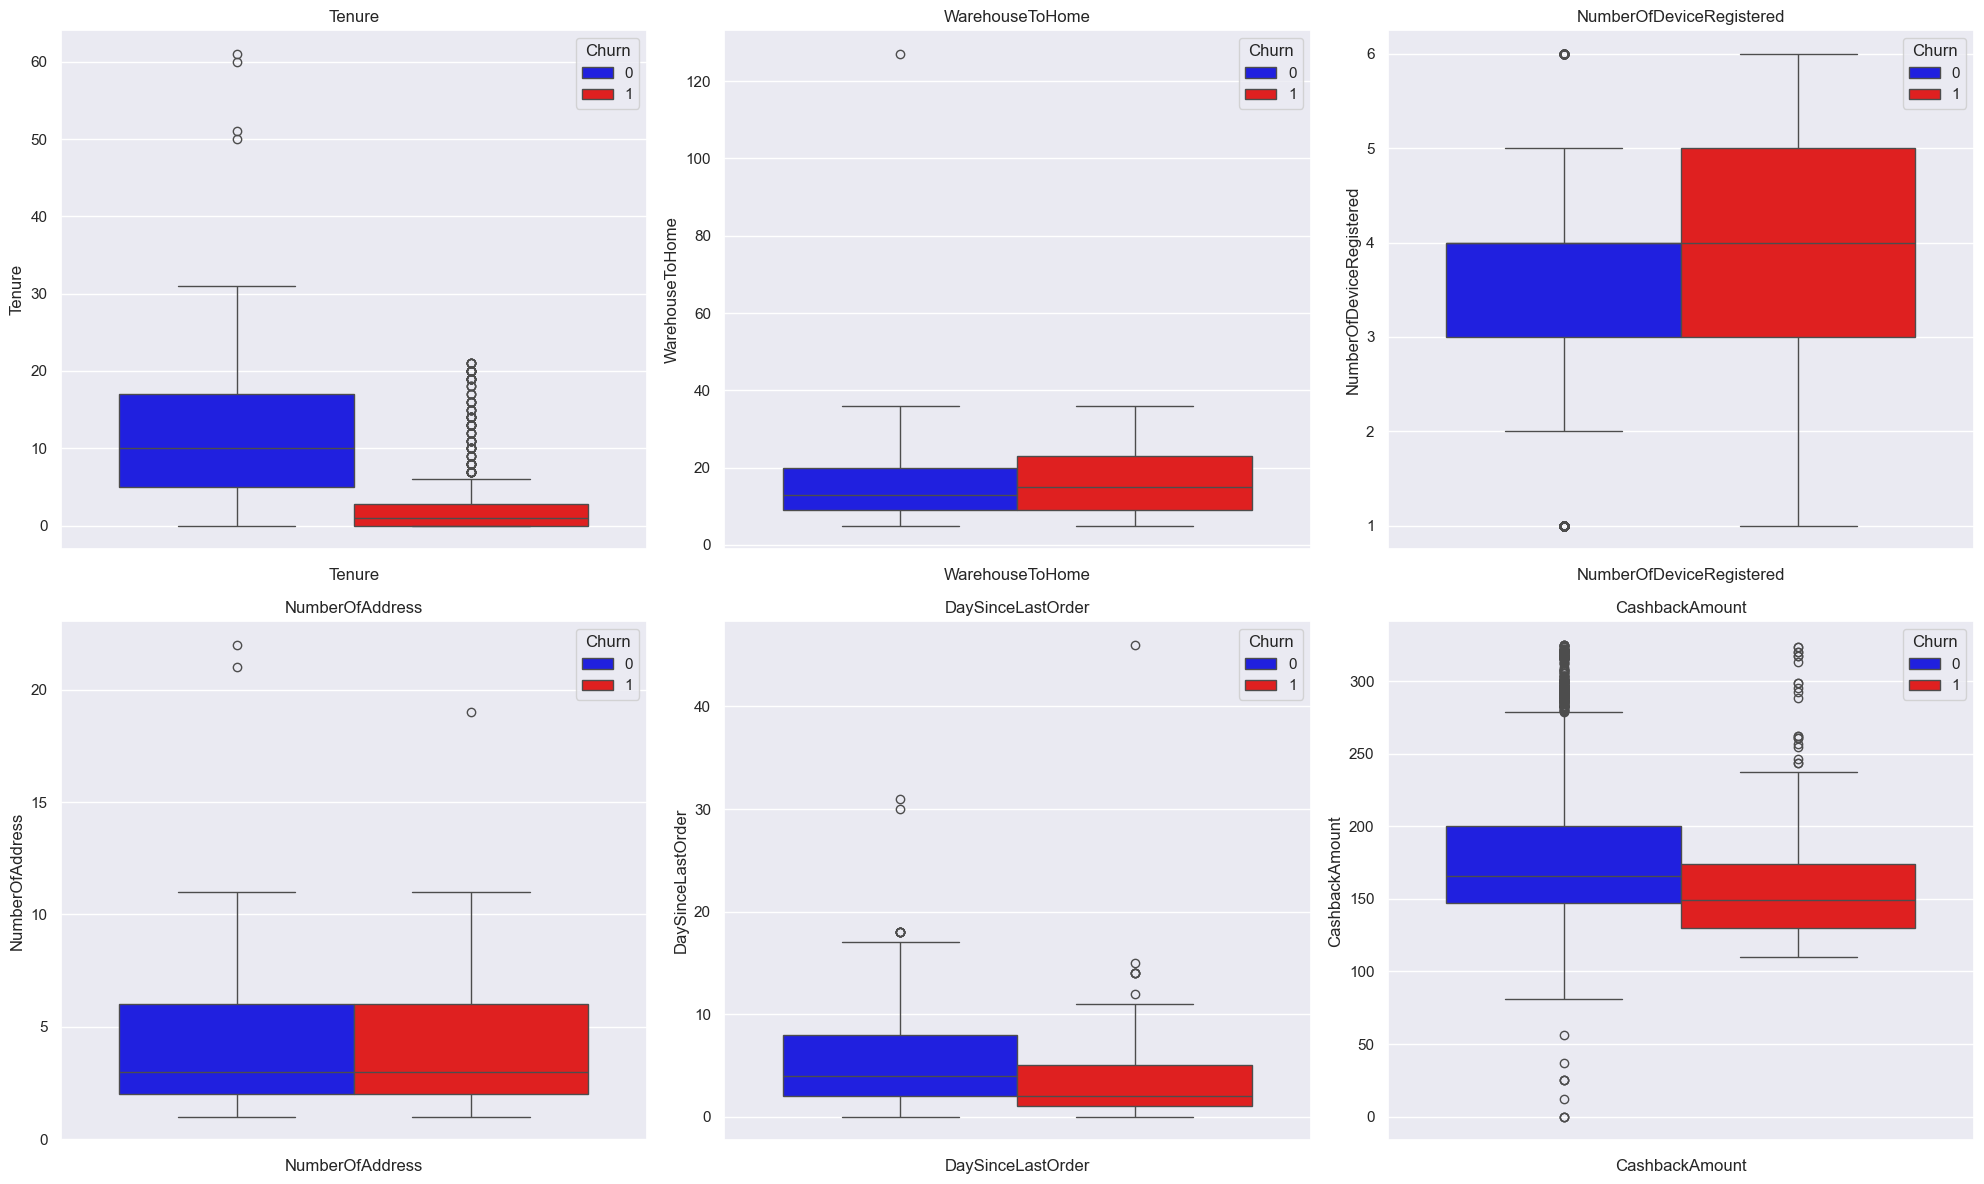

In [22]:
features = ['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered','NumberOfAddress',
            'DaySinceLastOrder', 'CashbackAmount']
plt.figure(figsize=(20, 12))
sns.set(palette=['Blue', 'Red'])
plotnumber = 1

for feature in features:
    ax = plt.subplot(2, 3, plotnumber)
    sns.boxplot(data=df, y=feature, hue='Churn')
    plt.xlabel(feature)
    plt.title(feature)
    plotnumber += 1
    plt.tight_layout();

> - Kolom Tenure, outlier pada kelas Churn dan Not Churn merupakan outlier yang masih bisa diterima dan masuk akal. Tenure atau lama bergabung yang nilainya besar bisa memberikan gambaran loyal customer.
> - Kolom WarehouseToHome memiliki outlier dimana pada kelas target Not Churn, terdapat data dengan jarak dari warehouse ke rumah lebih dari 100 km. Jumlah data dengan outlier tersebut adalah 1 baris data. Tidak dilakukan penghapusan outlier sebab masih sangat masuk akal untuk barang dikirimkan ke lokasi-lokasi yang jauh.
> - Kolom NumberOfDeviceRegistered memiliki outlier atas dan outlier bawah. Namun, outlier tersebut tidak perlu dihilangkan sebab menunjukkan jumlah device yang digunakan untuk login dan masih wajar untuk dapat login menggunakan 1 - 6 device yang berbeda.
> - Kolom CashbackAmount memiliki outlier atas maupun bawah pada kelas target Not Churn dan hanya outlier atas pada kelas target Churn. Cashback merupakan program promosi yang diberikan sehingga setiap orang bisa mendapatkan nilai promosi cashback yang berbeda bergantung pada besaran cashback dan total belanjanya. Pasti akan ada yg nilainya lebih tinggi dari kebanyakan atau lebih rendah. Outlier pada kolom ini tidak perlu dihapus.


In [23]:
# Outlier NumberOfAddress
df[df['NumberOfAddress'] > 15]

Tenure  WarehouseToHome  NumberOfDeviceRegistered    PreferedOrderCat  \
1581     NaN             10.0                         3              Mobile   
2109    13.0             16.0                         4  Laptop & Accessory   
3494    12.0             15.0                         3  Laptop & Accessory   

     SatisfactionScore MaritalStatus  NumberOfAddress Complain  \
1581                 2        Single               19        1   
2109                 4        Single               22        0   
3494                 4        Single               21        0   

      DaySinceLastOrder  CashbackAmount Churn  
1581                0.0          122.85     1  
2109                4.0          192.82     0  
3494                3.0          167.82     0

> Terdapat 3 baris data yang memiliki jumlah alamat lebih dari 15 alamat dalam 1 akun. Kondisi tersebut dianggap anomali karena tidak informasi apakah ecommerce ini merupakan business to business (B2B) sehingga dapat memiliki banyak alamat pengiriman. Namun, karena sebagaian besar data tersebar dalam rentang  2 -m7 alamat pengiriman per akun, maka lebih 15 alamat dianggap outlier yang perlu dihapus.

In [24]:
df = df[df['NumberOfAddress'] < 15]

In [25]:
# Outlier Kolom Tenure
df[df['DaySinceLastOrder'] > 25]

Tenure  WarehouseToHome  NumberOfDeviceRegistered PreferedOrderCat  \
181      3.0             11.0                         3           Mobile   
3591     0.0              6.0                         4          Fashion   
3830     4.0             12.0                         4     Mobile Phone   

     SatisfactionScore MaritalStatus  NumberOfAddress Complain  \
181                  5       Married                6        0   
3591                 3       Married                6        0   
3830                 5       Married                7        0   

      DaySinceLastOrder  CashbackAmount Churn  
181                30.0          132.04     0  
3591               46.0          206.09     1  
3830               31.0          157.04     0

> Terdapat data anomali dimana tenure atau lama bergabung selama 0 bulan namun daysincelastorder nya 46 hari (terhitung telah lebih dari 1 bulan). Dikarenakan merupakan outlier ekstrim dan data tidak masuk akal, maka akan dilakukan pengahapusan baris data tersebut.

In [26]:
df = df[df['DaySinceLastOrder'] < 40]

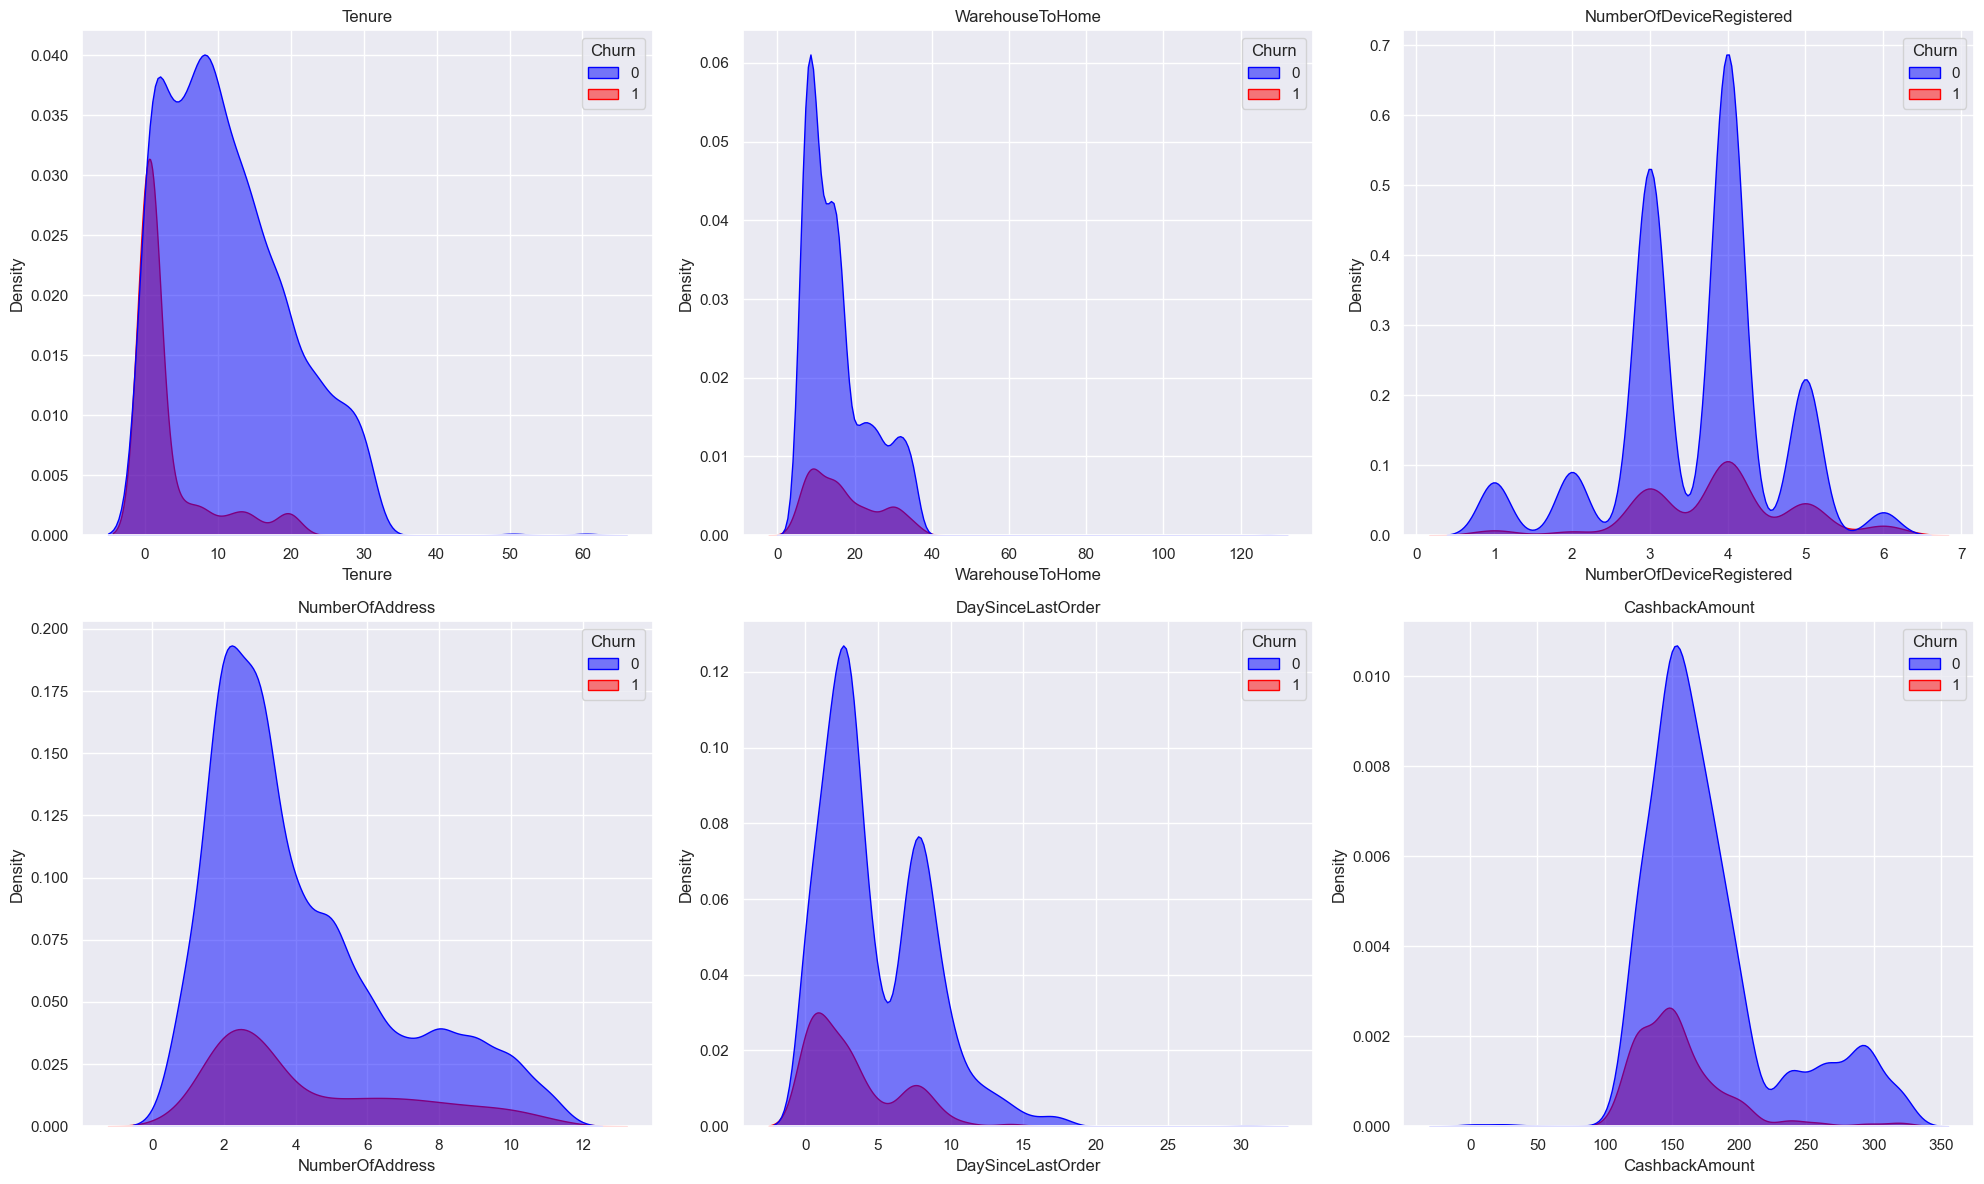

In [27]:
features = ['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered','NumberOfAddress',
            'DaySinceLastOrder', 'CashbackAmount']
plt.figure(figsize=(20, 12))
plotnumber = 1

for feature in features:
    ax = plt.subplot(2, 3, plotnumber)
    sns.kdeplot(data=df, x=feature, hue='Churn', fill=True, palette=['Blue', 'Red'], alpha=0.5);
    plt.xlabel(feature)
    plt.title(feature)
    plotnumber += 1
    plt.tight_layout();

> Pelanggan yang tergolong not churn menyebar sampai tenure > 30 bulan, sedangkan pelanggan churn sebaran tenurenya lebih pendek. Hal ini menandakan bahwa kecenderungan pelanggan not churn adalah pelanggan yang telah menggunakan layanan ecommerce lebih lama.

> Jarak warehouse ke rumah pada kategori churn dan not churn menyebar hampir sama sehingga jarak gudang ke rumah bukan penentu utama loyalitas pelanggan.

> Distribusi data churn dan not churn menyebar dan paling banyak terjadi jika jumlah device yang digunakan  sebanyak 3 - 5 device. Jumlah device bukan penentu utama loyalitas pelanggan meskipun pertambahan jumlah device terlihat lebih meningkatkan customer menjadi not churn.

> Jumlah alamat dalam satu akun pada kategori churn dan not churn menyebar hampir sama sehingga bukan penentu utama loyalitas pelanggan.

> Pelanggan yang tergolong not churn lebih menyebar dimana not churn juga terjadi pada hari pembelanjaan terakhir yang sudah cukup lama. Pelanggan hari sejak pembelanjaan terakhir lebih pendek. Hal ini menandakan bahwa pelanggan not churn bisa saja merupakan pelanggan yang juga telah lama tidak berbelanja namun cukup puas dengan layanannya. Contoh kasus adalah membeli barang elektronik yang cukup mahal dulu dan belum rusak sehingga sudah lama tidak membeli apapun di ecommerce tersebut.

> Customer churn lebih banyak terjadi pada kondisi dimana cashback yang diberikan lebih rendah. Sedangkan pada cashback yang lebih tinggi, jumlah churn menurun. Ini menandakan bahwa meningkatnya jumlah cashback dapat mempertahankan pelanggan.

#### **Bagaimana proporsi kelas target?**

In [28]:
df['Churn'].value_counts(normalize=True)

Churn
0    0.83029
1    0.16971
Name: proportion, dtype: float64

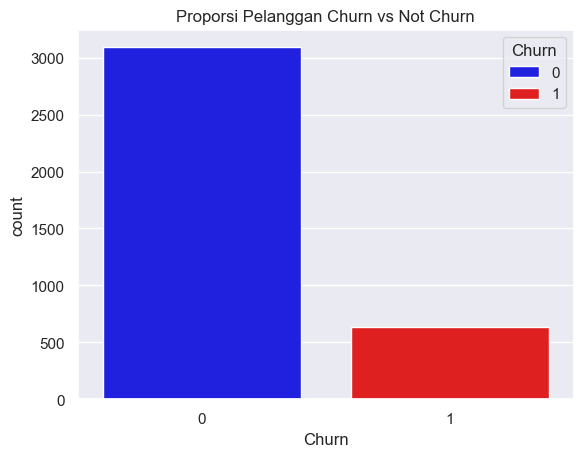

In [29]:
plt.title('Proporsi Pelanggan Churn vs Not Churn');
sns.countplot(data=df, x='Churn', hue='Churn', palette=['Blue', 'Red']);

> Sebanyak 83% data merupakan data pelanggan dengan kelas target 0 atau Not Churn sedangkan 17% sisanya merupakan pelanngan Churn. Hal ini menunjukkan adanya imbalanced target dimana target 1 dan 0 memiliki perbandingan mencapai 1 : 4.

#### **Bagaimana distribus target Churn vs Not Churn berdasarkan karateristik kategorikal nya?**


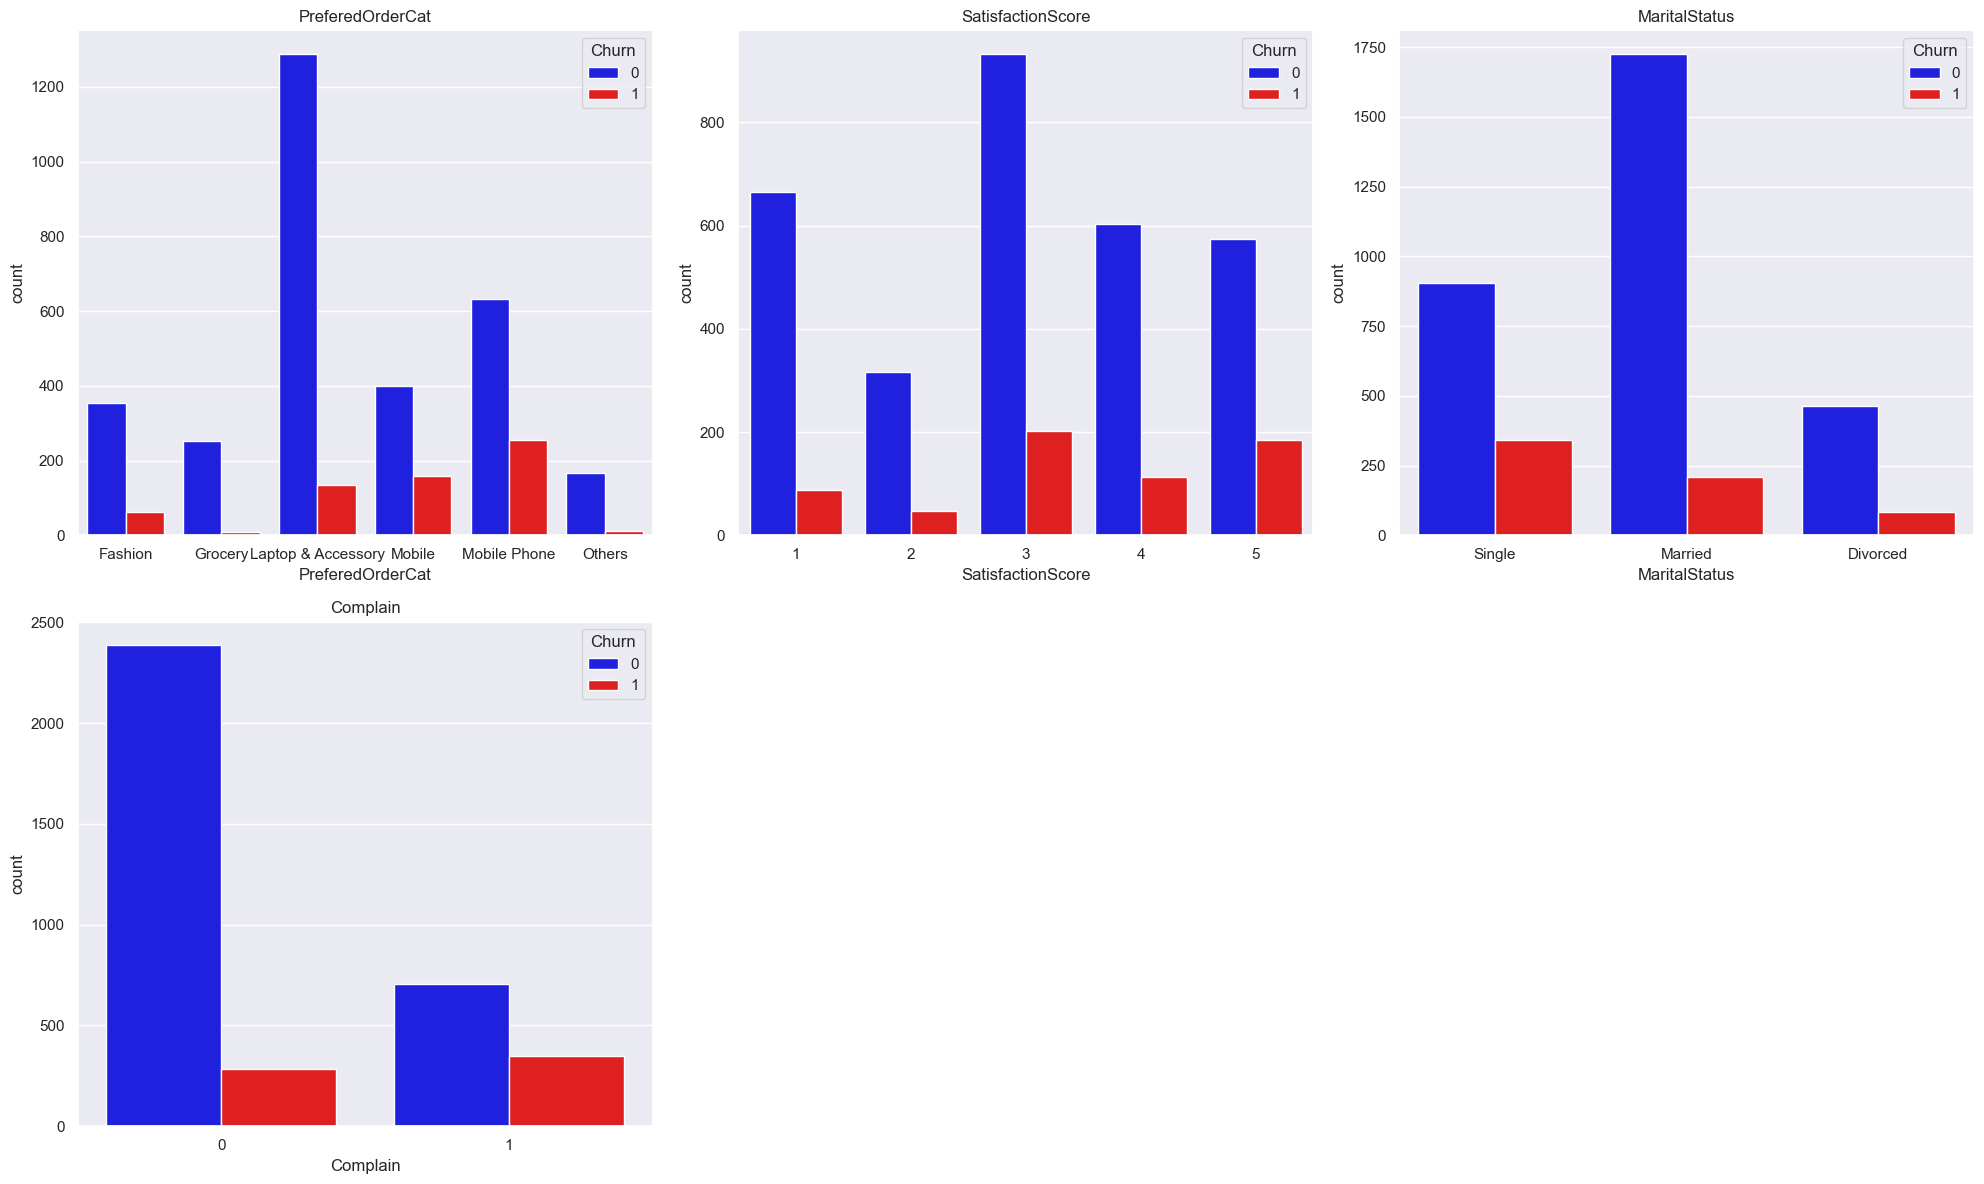

In [30]:
features = ['PreferedOrderCat', 'SatisfactionScore', 'MaritalStatus','Complain',]
plt.figure(figsize=(20, 12))
sns.set(palette=['Blue', 'Red'])
plotnumber = 1

for feature in features:
    ax = plt.subplot(2, 3, plotnumber)
    sns.countplot(data=df, x=feature, hue='Churn')
    plt.xlabel(feature)
    plt.title(feature)
    plotnumber += 1
    plt.tight_layout();

> Customer yang tergolong akan churn berbelanja produk dengan kategori terbanyak adalah mobile phone, mobile, dan laptop & accessory. Hal ini bisa terjadi dikarenakan produk-produk dalam kategori tersebut umumnya merupakan produk dengan harga yang lebih tinggi dibandingkan kategori lainnya. Adanya keluhan terhadap produk yang didapatkan dapat menyebabkan tingginya jumlah customer churn pada kategori barang tersebut.

> Jumlah customer churn tertinggi ada pada customer yang memiliki nilai kepuasan layanan 3 -5, namun customer not churn juga banyak yang memberikan nilai kepuasan 1 - 3. Hal ini menunjukkan SatisfactionScore bukan penentu utama loyalitas pelanggan ecommerce.

> Jumlah churn tertinggi terjadi pada pelanggan yang belum menikah atau single. Ini dapat terjadi mungkin dikarenakan pelanggan yang single dan masih hidup sendiri umumnya masih berusia muda dan sedang meniti karir sehingga lebih sensitif terhadap harga. Pelanggan seperti ini dapat mudah berpindah pada kompetitor jika harga barang yang ditawarkan lebih rendah.

> Jumlah proporsi dan jumlah total churn tertinggi terjadi pada pelanggan yang pernah mengajukan complain. Complain adalah bentuk adanya ketidakpuasan atau masalah dalam proses pembelian barang. Ini dapat menurunkan tingkat kepercayaan pelanggan yang berimplikasi pada hilangnya pelanggan.

#### **Bagaimana korelasi setiap fitur terhadap target?**


In [31]:
corr_cols = ['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'Complain', 'DaySinceLastOrder', 'CashbackAmount']
correlation_score = []
for i in corr_cols:
    corr_skor = df[i].corr(df['Churn'], method='spearman')
    correlation_score.append(corr_skor.round(2))

correlation_df = pd.DataFrame({'Column': corr_cols, 'Correlation Score': correlation_score})
correlation_df

Column  Correlation Score
0                    Tenure              -0.42
1           WarehouseToHome               0.07
2  NumberOfDeviceRegistered               0.10
3         SatisfactionScore               0.10
4           NumberOfAddress               0.02
5                  Complain               0.27
6         DaySinceLastOrder              -0.19
7            CashbackAmount              -0.20

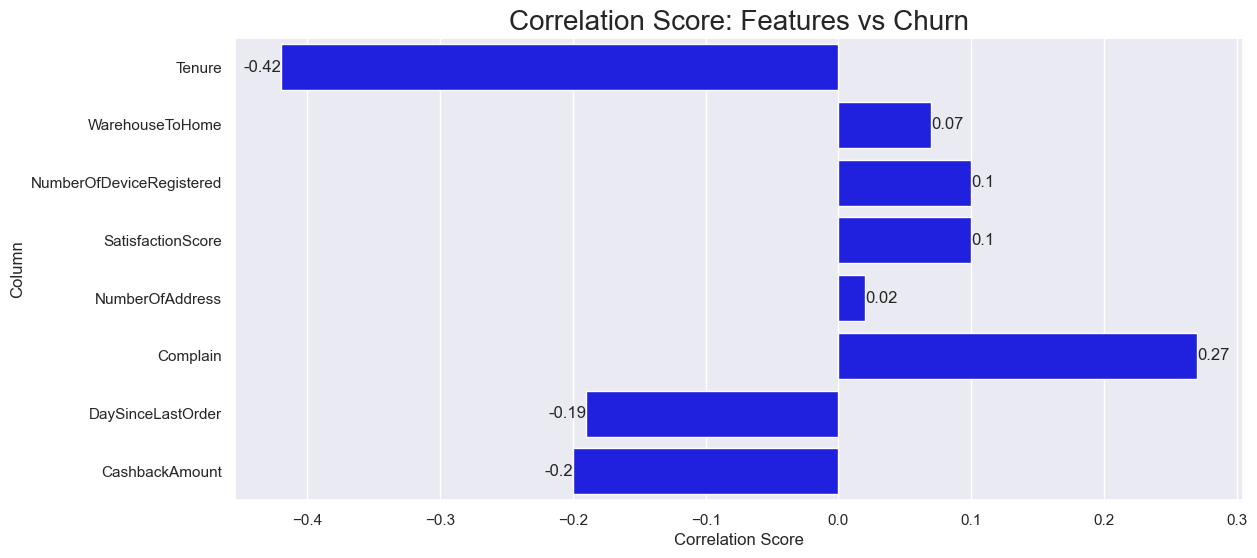

In [32]:
plt.figure(figsize=(13, 6))
plt.title('Correlation Score: Features vs Churn', size=20)
barplot = sns.barplot(data=correlation_df, x='Correlation Score', y='Column', color='Blue');
for container in barplot.containers:
    barplot.bar_label(container, label_type='edge');

> Tenure memiliki korelasi yang paling kuat terhadap kolom Churn serta hubungannya adalah negatif atau berbanding terbalik. Artinya, semakin lama seseorang telah menggunakan layanan pada ecommerce tersebut, maka akan semakin cenderung tergolong customer not churn (kelas 0), begitupun sebaliknya.

> Kolom Complain menjadi feature ke-2 dengan korelasi terkuat serta hubungannya adalah positif atau searah. Artinya, apabila seorang pelanggan pernah mengajukan complain (kelas 1), maka akan meningkatkan potensi pelanggan tersebut untuk churn (kelas 1).

## **3. Data Preparation**
- Define Features (X) and Target (y).
- Train - Test Splitting
- Data Pre-processing

### **Define Features (X) and Target (y)**

In [33]:
X = df.drop(columns='Churn')
y = df['Churn']

### **Train-Test Splitting**

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, stratify=y)

### **Pre-Processing**
- Missing Value
    + KNNImputer --> `Tenure`, `WarehouseToHome`
- Encoding
    + Onehot Encoding --> `PreferedOrderCat`, `MaritalStatus`
- Scaling
    + Robust Scaling --> `Tenure`, `WarehouseToHome`, `DaySinceLastOrder`, `CashbackAmount`

In [35]:
neighbors = np.sqrt(len(X_train)).round(0).astype(int)

pipe_Tenure = Pipeline([('missval', KNNImputer(n_neighbors=neighbors, weights='distance')),
                        ('rbst', RobustScaler())])

pipe_WarehouseToHome = Pipeline([('missval', KNNImputer(n_neighbors=neighbors, weights='distance')),
                                 ('rbst', RobustScaler())])

In [36]:
transformer = ColumnTransformer([('Tenure', pipe_Tenure, ['Tenure']),
                                  ('WarehouseToHome', pipe_WarehouseToHome, ['WarehouseToHome']),
                                  ('onehot', OneHotEncoder(drop='first'), ['PreferedOrderCat', 'MaritalStatus']),
                                  ('rbst', RobustScaler(), ['DaySinceLastOrder', 'CashbackAmount'])],
                                  remainder='passthrough')
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('Tenure',
                                 Pipeline(steps=[('missval',
                                                  KNNImputer(n_neighbors=55,
                                                             weights='distance')),
                                                 ('rbst', RobustScaler())]),
                                 ['Tenure']),
                                ('WarehouseToHome',
                                 Pipeline(steps=[('missval',
                                                  KNNImputer(n_neighbors=55,
                                                             weights='distance')),
                                                 ('rbst', RobustScaler())]),
                                 ['WarehouseToHome']),
                                ('onehot', OneHotEncoder(drop='first'),
                                 ['PreferedOrderCat', 'MaritalStatus']),
                                ('rbst', RobustScaler(),
                                 ['DaySinceLastOrder', 'CashbackAmount'])])

## **4. Cross Validation (Model Benchmark)**

In [37]:
# Base Learner
logreg = LogisticRegression(random_state=0)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=0)

# ensemble various
voting = VotingClassifier(estimators=[('logreg', logreg),
                                      ('knn', knn),
                                      ('dt', dt)]) 

stacking = StackingClassifier(estimators=[('logreg', logreg),
                                      ('knn', knn),
                                      ('dt', dt)])

# ensemble similar
bagging = BaggingClassifier(random_state=0, estimator=KNeighborsClassifier(), n_estimators=100)
rf = RandomForestClassifier(random_state=0)
adaboost = AdaBoostClassifier(random_state=0)
gradboost = GradientBoostingClassifier(random_state=0)
xgb = XGBClassifier(random_state=0, use_label_encoder=False)

In [38]:
list_model = [logreg, knn, dt, voting, stacking, bagging, rf, adaboost, gradboost, xgb]
list_all_score = []
list_mean_score = [] 
list_std = []
f2_score = make_scorer(fbeta_score, beta=2)


for model in list_model:
    # pipeline
    pipe_prep_model =  Pipeline([
        ('preprocessing', transformer),
        ('modeling', model)
    ])

    # cross val
    crossval = cross_val_score(estimator=pipe_prep_model,
                    X = X_train,
                    y = y_train,
                    cv = 5,
                    scoring = f2_score,
                    error_score='raise') # Jika terjadi error selama pelatihan atau evaluasi model, langsung raise (lemparkan) exception, dan hentikan proses

    # F2 score
    list_all_score.append(crossval.round(2))
    list_mean_score.append(crossval.mean())
    list_std.append(crossval.std())

In [39]:
df_f2 = pd.DataFrame()
df_f2['algo'] = list_model
df_f2['all_score'] = list_all_score
df_f2['mean_score'] = list_mean_score
df_f2['std_score'] = list_std

df_f2

algo  \
0                 LogisticRegression(random_state=0)   
1                             KNeighborsClassifier()   
2             DecisionTreeClassifier(random_state=0)   
3  VotingClassifier(estimators=[('logreg', Logist...   
4  StackingClassifier(estimators=[('logreg', Logi...   
5  BaggingClassifier(estimator=KNeighborsClassifi...   
6             RandomForestClassifier(random_state=0)   
7                 AdaBoostClassifier(random_state=0)   
8         GradientBoostingClassifier(random_state=0)   
9  XGBClassifier(base_score=None, booster=None, c...   

                        all_score  mean_score  std_score  
0   [0.48, 0.52, 0.43, 0.5, 0.48]    0.481057   0.030044  
1  [0.45, 0.47, 0.32, 0.39, 0.28]    0.383091   0.072632  
2   [0.77, 0.72, 0.71, 0.8, 0.73]    0.745738   0.034009  
3  [0.54, 0.57, 0.45, 0.56, 0.54]    0.530817   0.039822  
4  [0.72, 0.62, 0.56, 0.77, 0.62]    0.657136   0.072746  
5  [0.45, 0.46, 0.29, 0.39, 0.27]    0.372470   0.078782  
6  [0.69, 0.73, 0.63, 0.69, 0.68]    0.682103   0.032364  
7  [0.62, 0.61, 0.54, 0.61, 0.59]    0.593973   0.029115  
8  [0.62, 0.65, 0.57, 0.65, 0.59]    0.615569   0.033356  
9  [0.73, 0.77, 0.77, 0.77, 0.77]    0.763328   0.017315

> Hasil membangun model benchmark, model terbaik didapatkan dengan menggunakan pendekatan algoritma XGBClassifier dengan F2 Score sebesar 0.76

> Karena adanya imbalanced target dalam data, maka akan dicoba untuk membangun ulang model dengan melakukan oversampling

## **5. Cross Validation + Resampling**

In [40]:
smote = SMOTE(sampling_strategy='minority', random_state=0)

In [41]:
list_model = [logreg, knn, dt, voting, stacking, bagging, rf, adaboost, gradboost, xgb]
list_all_score = []
list_mean_score = [] 
list_std = []
f2_score = make_scorer(fbeta_score, beta=2)


for model in list_model:
    # pipeline
    pipe_prep_model =  Pipeline([
        ('preprocessing', transformer),
        ('smote', smote),
        ('modeling', model)
    ])

    # cross val
    crossval = cross_val_score(estimator=pipe_prep_model,
                    X = X_train,
                    y = y_train,
                    cv = 5,
                    scoring = f2_score,
                    error_score='raise') # Jika terjadi error selama pelatihan atau evaluasi model, langsung raise (lemparkan) exception, dan hentikan proses

    # F2 score
    list_all_score.append(crossval.round(2))
    list_mean_score.append(crossval.mean())
    list_std.append(crossval.std())

In [42]:
df_f2_smote = pd.DataFrame()
df_f2_smote['algo'] = list_model
df_f2_smote['all_score'] = list_all_score
df_f2_smote['mean_score'] = list_mean_score
df_f2_smote['std_score'] = list_std

df_f2_smote

algo  \
0                 LogisticRegression(random_state=0)   
1                             KNeighborsClassifier()   
2             DecisionTreeClassifier(random_state=0)   
3  VotingClassifier(estimators=[('logreg', Logist...   
4  StackingClassifier(estimators=[('logreg', Logi...   
5  BaggingClassifier(estimator=KNeighborsClassifi...   
6             RandomForestClassifier(random_state=0)   
7                 AdaBoostClassifier(random_state=0)   
8         GradientBoostingClassifier(random_state=0)   
9  XGBClassifier(base_score=None, booster=None, c...   

                        all_score  mean_score  std_score  
0  [0.69, 0.69, 0.65, 0.73, 0.66]    0.683361   0.029129  
1  [0.72, 0.71, 0.66, 0.72, 0.68]    0.698777   0.022796  
2   [0.69, 0.7, 0.69, 0.73, 0.69]    0.699482   0.014984  
3   [0.78, 0.78, 0.73, 0.78, 0.7]    0.756326   0.033503  
4    [0.73, 0.7, 0.66, 0.75, 0.7]    0.707894   0.032252  
5  [0.75, 0.71, 0.66, 0.72, 0.69]    0.707977   0.030283  
6  [0.77, 0.78, 0.68, 0.74, 0.74]    0.742764   0.034115  
7   [0.69, 0.71, 0.63, 0.7, 0.65]    0.673751   0.028820  
8  [0.74, 0.73, 0.61, 0.68, 0.66]    0.685115   0.048975  
9  [0.79, 0.78, 0.76, 0.77, 0.79]    0.775554   0.012539

> Model terbaik didapatkan menggunakan algoritma XGBClassifier dengan F2 score sebesar 0.77

## **6. Hyperparameter Tuning**

In [43]:
# pipeline
pipe_prep_model =  Pipeline([
        ('preprocessing', transformer),
        ('resampling', smote),
        ('modeling', xgb)
    ])

# hyperparam
hyperparam = {
    'modeling__max_depth': [3, 5, 7, 9, 11, 13],                    # Maksimal kedalaman pohon
    'modeling__learning_rate': [0.01, 0.1, 0.15, 0.2],              # Kecepatan belajar
    'modeling__n_estimators': [100, 200, 300],                      # Jumlah boosting rounds
}

# Randomized search
randomizedsearch = RandomizedSearchCV(
    estimator = pipe_prep_model,
    cv = 5,
    n_jobs = -1,
    param_distributions = hyperparam,
    scoring = f2_score,
    n_iter = 100
)

In [44]:
randomizedsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('Tenure',
                                                                               Pipeline(steps=[('missval',
                                                                                                KNNImputer(n_neighbors=55,
                                                                                                           weights='distance')),
                                                                                               ('rbst',
                                                                                                RobustScaler())]),
                                                                               ['Tenure']),
                                                                              ('WarehouseToHome',
                                                                               Pipeline(steps=[('missval',
                                                                                                KNNImputer(n_neighbors=55,
                                                                                                           weights='distance')),
                                                                                               ('rbst',
                                                                                                Robu...
                                                            missing=nan,
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=None,
                                                            num_parallel_tree=None, ...))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'modeling__learning_rate': [0.01, 0.1,
                                                                    0.15, 0.2],
                                        'modeling__max_depth': [3, 5, 7, 9, 11,
                                                                13],
                                        'modeling__n_estimators': [100, 200,
                                                                   300]},
                   scoring=make_scorer(fbeta_score, response_method='predict', beta=2))

In [45]:
randomizedsearch.best_score_

0.780500636758033

In [46]:
randomizedsearch.best_params_

{'modeling__n_estimators': 200,
 'modeling__max_depth': 11,
 'modeling__learning_rate': 0.2}

> Setelah dilakukan hyperparameter tuning, F2 Score dari model XGBoost meningkat dari yang sebelumnya 0.77 menjadi 0.78

## **7. Predict to Test Set**

### **Before Tuning**

In [47]:
pipe_prep_model =  Pipeline([
        ('preprocessing', transformer),
        ('resampling', smote),
        ('modeling', xgb)
    ])

pipe_prep_model.fit(X_train, y_train)

y_pred_before = pipe_prep_model.predict(X_test)

fbeta_score(y_test, y_pred_before, beta=2)

0.8596214511041009

In [48]:
print('XGBoost Before Tuning')
print(classification_report(y_test, y_pred_before))

XGBoost Before Tuning
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       619
           1       0.84      0.87      0.85       126

    accuracy                           0.95       745
   macro avg       0.91      0.92      0.91       745
weighted avg       0.95      0.95      0.95       745



### **After Tuning**

In [49]:
best_model = randomizedsearch.best_estimator_

best_model.fit(X_train, y_train)

y_pred_after = best_model.predict(X_test)

fbeta_score(y_test, y_pred_after, beta=2)

0.8650793650793651

In [50]:
print('XGBoost After Tuning')
print(classification_report(y_test, y_pred_after))

XGBoost After Tuning
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       619
           1       0.87      0.87      0.87       126

    accuracy                           0.95       745
   macro avg       0.92      0.92      0.92       745
weighted avg       0.95      0.95      0.95       745



## **8. ROC and AUC**

In [51]:
## ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_after)

## AUC
auc_score = roc_auc_score(y_test, y_pred_after)
auc_score

0.9188078570146422

> AUC score dari model XGBoost setelah tuning sebesar 0.91 yang menandakan bahwa model sangat baik dalam membedakan dua kelas yakni kelas positif (Churn) dan kelas negatif (Not Churn)

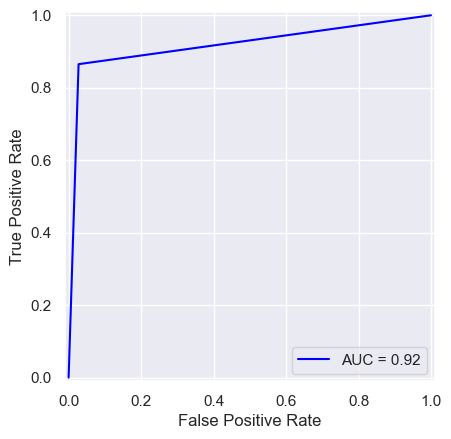

In [52]:
# ROC Curve
ROC_curve = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_score)
ROC_curve.plot();

> Kurva ROC menekuk tajam ke atas yang artinya model memiliki kemampuan yang baik membedakan antara kelas positif dan negatif.

> Bentuk kurva tersebut menunjukkan bahwa model mampu mendeteksi banyak positif dengan sedikit kesalahan negatif.

## **9. Features Importance**

In [53]:
col1 = list(best_model['preprocessing'].transformers_[0][1].get_feature_names_out())
col2 = list(best_model['preprocessing'].transformers_[2][1].get_feature_names_out())
col3 = list(best_model['preprocessing'].transformers_[3][1].get_feature_names_out())
col4 = list(best_model['preprocessing'].transformers_[4][1].get_feature_names_out())

all_col = col1 + col2 + col3 + col4 + ['WarehouseToHome']

In [54]:
best_model['modeling'].feature_importances_

array([0.17553726, 0.0218523 , 0.02913796, 0.07202865, 0.04205037,
       0.03307014, 0.04668306, 0.05787955, 0.04487002, 0.03709796,
       0.03191997, 0.03601313, 0.03399754, 0.03944625, 0.29841578],
      dtype=float32)

In [55]:
feature_import = pd.DataFrame()
feature_import['Feature'] = all_col
feature_import['Importance'] = best_model['modeling'].feature_importances_
feature_import = feature_import.sort_values(by='Importance', ascending=False)
feature_import = feature_import.reset_index(drop=True)
feature_import

Feature  Importance
0                       WarehouseToHome    0.298416
1                                Tenure    0.175537
2               PreferedOrderCat_Mobile    0.072029
3                  MaritalStatus_Single    0.057880
4                 MaritalStatus_Married    0.046683
5                     DaySinceLastOrder    0.044870
6         PreferedOrderCat_Mobile Phone    0.042050
7                              Complain    0.039446
8                        CashbackAmount    0.037098
9                     SatisfactionScore    0.036013
10                      NumberOfAddress    0.033998
11              PreferedOrderCat_Others    0.033070
12             NumberOfDeviceRegistered    0.031920
13  PreferedOrderCat_Laptop & Accessory    0.029138
14             PreferedOrderCat_Grocery    0.021852

> Semua fitur memiliki pengaruh penting. Tidak ada yang perlu dihilangkan. Fitur terpenting adalah jarak warehouse ke rumah customer (WarehouseToHome) dengan pengaruh sebesar 29%.

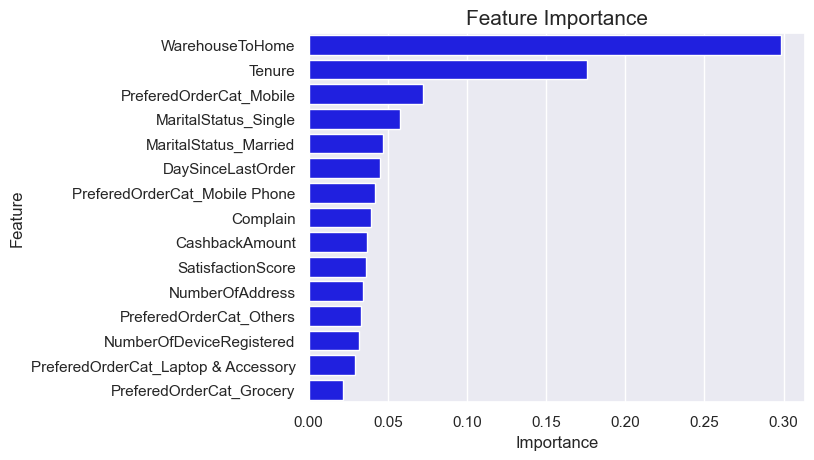

In [56]:
plt.title('Feature Importance', fontsize=15);
sns.barplot(data=feature_import, y='Feature', x='Importance', color='Blue');

## **10. Final Model and Saving Model**

In [57]:
randomizedsearch.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Tenure',
                                                  Pipeline(steps=[('missval',
                                                                   KNNImputer(n_neighbors=55,
                                                                              weights='distance')),
                                                                  ('rbst',
                                                                   RobustScaler())]),
                                                  ['Tenure']),
                                                 ('WarehouseToHome',
                                                  Pipeline(steps=[('missval',
                                                                   KNNImputer(n_neighbors=55,
                                                                              weights='distance')),
                                                                  ('rbst',
                                                                   RobustScaler())]),
                                                  ['WarehouseToHome'])...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=11, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])

### **Pickle**

In [58]:
# best model
xgb_tuning = randomizedsearch.best_estimator_

# fit
xgb_tuning.fit(X, y)

# save with pickle
pickle.dump(xgb_tuning, open('../Model/model_XGBoost_Ecommerce_Churn.sav', 'wb'))

### **Joblib**

In [59]:
# best model
xgb_tuning = randomizedsearch.best_estimator_

# fit
xgb_tuning.fit(X, y)

# save model
joblib.dump(xgb_tuning, '../Model/model_XGBoost_Ecommerce_Churn_joblib')

['../Model/model_XGBoost_Ecommerce_Churn_joblib']

## **11. Model Interpretation**

In [60]:
# Start js (must have)
shap.initjs()

In [61]:
# ambil model dan data dari pipeline
my_model = xgb_tuning[-1]
my_data = xgb_tuning[0].transform(X_train)

# define explainer
explainer_shap = shap.TreeExplainer(
    model= my_model,
    data= my_data
)

# hitung shap value untuk tiap baris di data train
shap_values = explainer_shap.shap_values(my_data)

 98%|===================| 2923/2979 [00:37<00:00]        

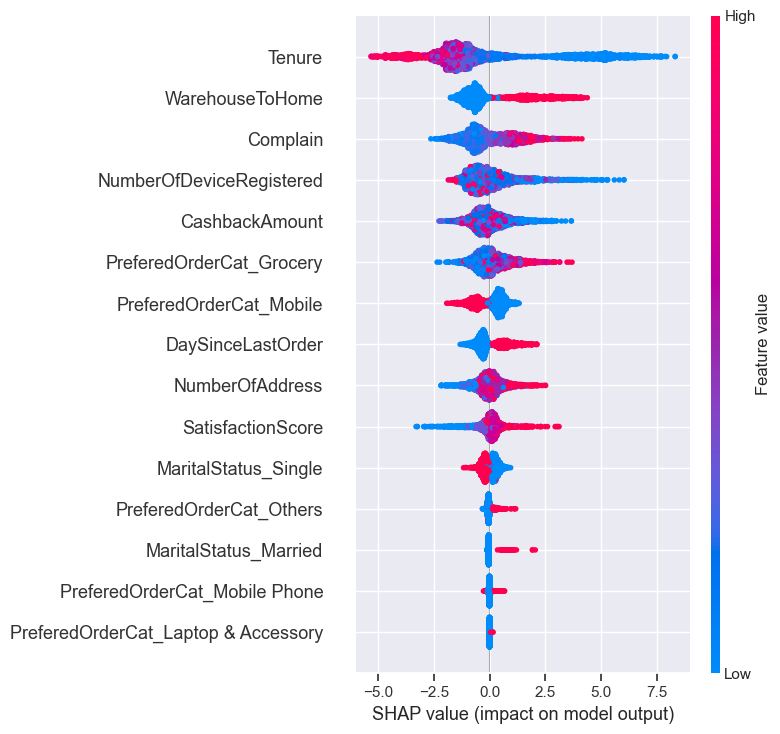

In [62]:
shap.summary_plot(shap_values, my_data, feature_names=all_col)

### ü™Ñ **Model Interpretation Berdasarkan SHAP Analysis**
- `Tenure`
    + Semakin rendah Tenure seorang pelanggan (baru bergabung dalam waktu dekat), maka akan memiliki kecenderungan untuk Churn.
- `WarehouseToHome`
    + Semakin jauh jarak rumah seorang pelanggan dengan warehouse, maka akan cenderung pelanggan tersebut untuk Churn.
- `Complain`
    + Semakin banyak complain yang diajukan oleh pelanggan, maka pelanggan tersebut akan cenderung Churn.
- `NumberofDeviceRegistered`
    + eorang pelanggan yang registrasi dari sedikit device, maka akan cenderung menjadi pelanggan Churn.
- `CashbackAmount`
    + Pelanggan yang mendapatkan cashback dengan jumlah yang kecil, akan cenderung untuk Churn.
- `PreferedOrderCat_Grocery`
    + Pelanggan yang menyukai barang dengan kategori Grocery cenderung akan lebih mudah Churn. Ini mungkin disebabkan karena kebutuhan rumah tangga biasanya dibeli setelah melihat harga di berbagai tempat. Pelanggan grocery lebih mudah churn apabila menemukan barang yang sama dengan harga lebih murah atau kualitas lebih baik di tempat lain.
- `PreferedOrderCat_Mobile`
    + Pelanggan yang menyukai barang dengan kategori mobile cenderung tidak akan churn.
- `DaySinceLastOrder`
    + Pelanggan yang sudah lama tidak berbelanja, cenderung akan menjadi Churn.
- `NumberofAddress`
    + Jumlah alamat yang tersimpan dalam sutu akun pelanggan kurang dapat menentukan kecenderungan pelanggan untuk Churn maupun Not Churn. Namun, jika semakin banyak alamat yang tersimpan sedikit akan memberikan pengaruh pelanggan menjadi lebih churn.
- `SatisfactionScore`
    + Skor kepuasan pelanggan kurang dapat menentukan kecenderungan pelanggan untuk Churn maupun Not Churn. Namun, jika semakin sedikit skor yang diberikan akan memberikan pengaruh pelanggan menjadi lebih tidak churn.
- `MaritalStatus_Single`
    + Pelanggan yang single maupun tidak single kurang memberikan pengaruh terhadap keputusan apakah pelanggan churn atau not churn, Namun, apabila pelanggan single akan sedikit lebih mengarah untuk tidak churn.
- `PreferedOrderCat_Others`
    + Pelanggan yang menyukai barang selain kategori fashion, mobile, mobile phone, atau laptop & accessories akan cenderung menjadi pelanggan churn.
- `MaritalStatus_Married`
    + Pelanggan yang sudah menikah cenderung akan menjadi pelanggan yang churn. Hal ini mungkin berkaitan dengan kebutuhan rumah tangga yang mana lebih mudah churn apabila menemukan barang yang sama dengan harga lebih murah atau kualitas lebih baik di tempat lain.
- `PreferedOrderCat_Mobile Phone`
    + Pelanggan yang menyukai barang dengan kategori mobile phone cenderung akan lebih mudah untuk churn.
- `PreferedOrderCat_Laptop & Accessory`
    + Pelanggan yang menyukai maupun bukan penyuka barang dengan kategori Laptop & Accessory kurang dapat menjadi penentu apakah ia akan churn atau tidak churn.

## **12. Summary**

### üí∞ **Summary**
**Model --> Extreme Gradient Boosting (XGBoost)**

**Apa itu XGBoost?**

XGBoost (Extreme Gradient Boosting) Model adalah algoritma machine learning berbasis pohon keputusan (decision tree) yang menggunakan teknik boosting untuk meningkatkan akurasi model prediktif.

**Bagaimana cara kerja XGBoost?**
- Boosting --> Membuat model secara berurutan dimana model selanjutnya memperbaiki kesalahan model sebelumnya.
- Gradient Descent --> Kesalahan model dihitung dan digunakan untuk memperbaiki model berikutnya melalui pendekatan gradien.
- Kemudian semua model kecil digabung membentuk final model yang kuat.

**Spesifikasi Model**
- n_estimators = 200
- max_depth = 11
- learning_rate = 0.2

**Train Set F2 Score:**
- Before tuning: 0.77
- After tuning: 0.78

**Test Set F2 Score:**
-  Before tuning: 0.85
-  After tuning: 0.86

---

Hyperparameter tuning meningkatkan F2 score pada train set maupun test set mengguakan model Extreme Gradient Boosting. 

Performa model XGBoost setelah tuning sebesar 0.86, dimana angka tersebut menunjukkan bahwa model sudah cukup baik dalam memprediksi seseorang pelanggan akan churn (kelas positif: 1)

Metric F2 Score digunakan karena cost function dari False Negative dianggap hampir sama besar dengan cost False Positif namun lebih memperhatikan false negatif karena lebih tinggi costnya, sehingga jumlah FN maupun FP harus balance (sama-sama rendah) dengan FN lebih rendah. 


In [63]:
cm = confusion_matrix(y_test, y_pred_after)
cm

array([[602,  17],
       [ 17, 109]], dtype=int64)

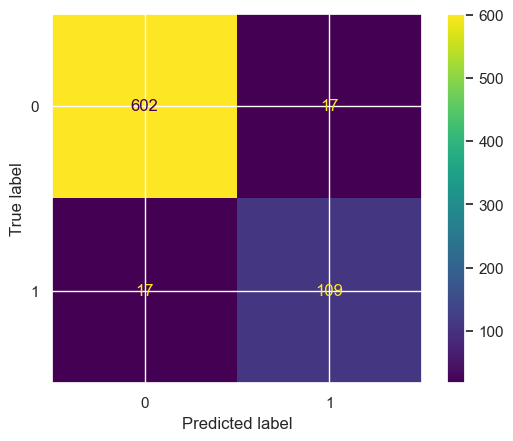

In [64]:
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot();

In [65]:
y_test.value_counts()

Churn
0    619
1    126
Name: count, dtype: int64

### üìù **Perhitungan Kerugian Perusahaan**

Berdasarkan confusion matrix, dapat dihitung kerugian perusahaan jika seseorang pelanggan churn.

**Sebelum Implementasi Model ML XGBoost:**

= Jumlah Churn * EstimatedCLV

= 126 * $3150

= $396900

**Setelah Implementasi Model ML Decision Tree:**

= (FP * Biaya Promosi) + (FN * EstimatedCLV)

= (17 * $10) + (17 * $3150)

= $170 + $53550

= $53720

**Perusahaan bisa menekan kerugian yang dialami setelah implementasi model ML sebesar $343180**